# Курс «Библиотеки Python для Data Science: продолжение»

## Пример

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

__Урок 1__

__Описание датасета__

- __LIMIT_BAL__ - Сумма предоставленного кредита
- __SEX__ - Пол (1=мужчина, 2=женщина)
- __EDUCATION__ - Образование (1=аспирантура, 2=университет, 3=старшая школа, 4=прочее, 5=неизвестно, 6=неизвестно)
- __MARRIAGE__ - Семейное положение (1=женат/замужен, 2=не женат/не замуженм, 3=прочее)
- __AGE__ - Возраст (в годах)
- __PAY_1__ - Статус погашения в Сентябре (-1=погашен полностью, 0=погашен частично, 1=отсрочка платежа на один месяц, .., 3=отсрочка платежа на три месяца и более)
- __PAY_2__ - Статус погашения в Августе
- __PAY_3__ - Статус погашения в Июле
- __PAY_4__ - Статус погашения в Июне
- __PAY_5__ - Статус погашения в Мае
- __PAY_6__ - Статус погашения в Апреле
- __BILL_AMT1__ - Сумма выписки по счету в Сентябре
- __BILL_AMT2__ - Сумма выписки по счету в Августе
- __BILL_AMT3__ - Сумма выписки по счету в Июле
- __BILL_AMT4__ - Сумма выписки по счету в Июне
- __BILL_AMT5__ - Сумма выписки по счету в Мае
- __BILL_AMT6__ - Сумма выписки по счету в Апреле
- __PAY_AMT1__ - Сумма предыдущего платежа в Сентябре
- __PAY_AMT2__ - Сумма предыдущего платежа в Августе
- __PAY_AMT3__ - Сумма предыдущего платежа в Июле
- __PAY_AMT4__ - Сумма предыдущего платежа в Июне
- __PAY_AMT5__ - Сумма предыдущего платежа в Мае
- __PAY_AMT6__ - Сумма предыдущего платежа в Апреле
- __NEXT_MONTH_DEFAULT__ - Просрочка платежа в следующем месяце (1=да, 0=нет)

__Подключение библиотек и скриптов__

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

__Пути к директориям и файлам__

In [4]:
# input
DATASET_PATH = 'training_project_data.csv'

# output
PREP_DATASET_PATH = 'training_project_data_prep.csv'

SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

### Загрузка данных

In [5]:
df = pd.read_csv(DATASET_PATH)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT
0,150000.0,2,2,2,24,1,2,0,0,0,...,17853.0,34527.0,28277.0,0.0,2145.0,10000.0,22000.0,3000.0,5093.0,0
1,50000.0,2,3,1,46,3,3,3,3,2,...,30748.0,30162.0,30016.0,0.0,0.0,0.0,0.0,3100.0,798.0,1
2,150000.0,2,2,1,41,-1,-1,-1,-1,0,...,6784.0,6923.0,14116.0,0.0,0.0,6784.0,159.0,167.0,760.0,0
3,150000.0,2,2,2,35,0,0,0,0,0,...,55182.0,48983.0,50136.0,3500.0,2000.0,20000.0,2000.0,2000.0,2000.0,0
4,70000.0,2,1,1,35,1,2,2,2,2,...,47026.0,45971.0,47573.0,0.0,6500.0,1800.0,0.0,2500.0,2000.0,0


In [6]:
df.shape

(10000, 24)

In [7]:
df.iloc[0]

LIMIT_BAL             150000.0
SEX                        2.0
EDUCATION                  2.0
MARRIAGE                   2.0
AGE                       24.0
PAY_1                      1.0
PAY_2                      2.0
PAY_3                      0.0
PAY_4                      0.0
PAY_5                      0.0
PAY_6                      0.0
BILL_AMT1              65542.0
BILL_AMT2              28311.0
BILL_AMT3              23978.0
BILL_AMT4              17853.0
BILL_AMT5              34527.0
BILL_AMT6              28277.0
PAY_AMT1                   0.0
PAY_AMT2                2145.0
PAY_AMT3               10000.0
PAY_AMT4               22000.0
PAY_AMT5                3000.0
PAY_AMT6                5093.0
NEXT_MONTH_DEFAULT         0.0
Name: 0, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LIMIT_BAL           10000 non-null  float64
 1   SEX                 10000 non-null  int64  
 2   EDUCATION           10000 non-null  int64  
 3   MARRIAGE            10000 non-null  int64  
 4   AGE                 10000 non-null  int64  
 5   PAY_1               10000 non-null  int64  
 6   PAY_2               10000 non-null  int64  
 7   PAY_3               10000 non-null  int64  
 8   PAY_4               10000 non-null  int64  
 9   PAY_5               10000 non-null  int64  
 10  PAY_6               10000 non-null  int64  
 11  BILL_AMT1           10000 non-null  float64
 12  BILL_AMT2           10000 non-null  float64
 13  BILL_AMT3           10000 non-null  float64
 14  BILL_AMT4           10000 non-null  float64
 15  BILL_AMT5           10000 non-null  float64
 16  BILL_

### Приведение типов

In [9]:
for colname in ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    df[colname] = df[colname].astype(str)

In [10]:
df.dtypes

LIMIT_BAL             float64
SEX                    object
EDUCATION              object
MARRIAGE               object
AGE                     int64
PAY_1                  object
PAY_2                  object
PAY_3                  object
PAY_4                  object
PAY_5                  object
PAY_6                  object
BILL_AMT1             float64
BILL_AMT2             float64
BILL_AMT3             float64
BILL_AMT4             float64
BILL_AMT5             float64
BILL_AMT6             float64
PAY_AMT1              float64
PAY_AMT2              float64
PAY_AMT3              float64
PAY_AMT4              float64
PAY_AMT5              float64
PAY_AMT6              float64
NEXT_MONTH_DEFAULT      int64
dtype: object

### Обзор данных

__Обзор целевой переменной__

In [11]:
df['NEXT_MONTH_DEFAULT'].value_counts()

0    7805
1    2195
Name: NEXT_MONTH_DEFAULT, dtype: int64

__Обзор количественных признаков__

In [12]:
df.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,168182.000000,35.39600,51490.560500,49298.972000,47292.40850,43605.665800,40347.829700,38996.784300,5511.82970,5.931217e+03,5385.050600,4585.585700,4712.134300,5055.019400,0.219500
std,130118.668771,9.19536,74906.094564,71808.952137,69398.13263,65062.788893,61044.676044,59682.999879,14748.85889,2.204220e+04,18527.041096,14066.147593,14080.847065,17359.210922,0.413929
min,10000.000000,21.00000,-11545.000000,-24704.000000,-157264.00000,-65167.000000,-23003.000000,-339603.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.00000,3388.000000,3016.500000,2561.75000,2400.000000,1703.250000,1300.750000,1000.00000,7.492500e+02,390.000000,277.250000,300.000000,150.750000,0.000000
50%,140000.000000,34.00000,22896.500000,21576.000000,20370.50000,19194.000000,18261.000000,17338.000000,2163.50000,2.001000e+03,1800.000000,1500.000000,1543.000000,1500.000000,0.000000
75%,240000.000000,41.00000,67834.750000,64243.500000,60783.25000,55731.250000,50491.000000,49696.000000,5001.00000,5.000000e+03,4651.500000,4014.250000,4100.000000,4000.000000,0.000000
max,1000000.000000,75.00000,964511.000000,983931.000000,689643.00000,891586.000000,927171.000000,961664.000000,493358.00000,1.227082e+06,896040.000000,432130.000000,417990.000000,422000.000000,1.000000


__Обзор номинативных признаков__

In [13]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

SEX

2    6068
1    3932
Name: SEX, dtype: int64
****************************************************************************************************

EDUCATION

2    4678
1    3496
3    1674
5      90
4      42
6      18
0       2
Name: EDUCATION, dtype: int64
****************************************************************************************************

MARRIAGE

2    5332
1    4547
3     108
0      13
Name: MARRIAGE, dtype: int64
****************************************************************************************************

PAY_1

0     4895
-1    2852
1     1217
2      881
3      155
Name: PAY_1, dtype: int64
****************************************************************************************************

PAY_2

0     5178
-1    3318
2     1318
3      175
1       11
Name: PAY_2, dtype: int64
****************************************************************************************************

PAY_3

0     5200
-1    3379
2     1288
3      131
1        2
Name: PAY_3, 

### Обработка пропусков

In [14]:
len(df) - df.count()

LIMIT_BAL             0
SEX                   0
EDUCATION             0
MARRIAGE              0
AGE                   0
PAY_1                 0
PAY_2                 0
PAY_3                 0
PAY_4                 0
PAY_5                 0
PAY_6                 0
BILL_AMT1             0
BILL_AMT2             0
BILL_AMT3             0
BILL_AMT4             0
BILL_AMT5             0
BILL_AMT6             0
PAY_AMT1              0
PAY_AMT2              0
PAY_AMT3              0
PAY_AMT4              0
PAY_AMT5              0
PAY_AMT6              0
NEXT_MONTH_DEFAULT    0
dtype: int64

### Обработка выбросов

#### EDUCATION

In [15]:
df.loc[df['EDUCATION'] == '0', 'EDUCATION'] = df['EDUCATION'].mode()[0]

#### MARRIAGE

In [16]:
df.loc[df['MARRIAGE'] == '0', 'MARRIAGE'] = df['MARRIAGE'].mode()[0]

#### Построение новых признаков

__Id__

In [17]:
df['ID'] = df.index.tolist()

__Dummies__

In [18]:
df['IS_MALE'] = df['SEX'].map({'1':'1', '2':'0'}).astype(int)

In [19]:
for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

#### Сохранение обучающего датасета

In [20]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_4_2,PAY_4_3,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3
0,150000.0,2,2,2,24,1,2,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50000.0,2,3,1,46,3,3,3,3,2,...,0,1,0,0,1,0,0,1,0,0
2,150000.0,2,2,1,41,-1,-1,-1,-1,0,...,0,0,0,1,0,0,0,1,0,0
3,150000.0,2,2,2,35,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,70000.0,2,1,1,35,1,2,2,2,2,...,1,0,0,0,1,0,0,1,0,0


__Урок 2__

In [21]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_4_2,PAY_4_3,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3
0,150000.0,2,2,2,24,1,2,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50000.0,2,3,1,46,3,3,3,3,2,...,0,1,0,0,1,0,0,1,0,0
2,150000.0,2,2,1,41,-1,-1,-1,-1,0,...,0,0,0,1,0,0,0,1,0,0
3,150000.0,2,2,2,35,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,70000.0,2,1,1,35,1,2,2,2,2,...,1,0,0,0,1,0,0,1,0,0


__Выделение целевой переменной и групп признаков__

In [22]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

### Анализ целевой переменной

__Обзор распределения__

In [23]:
df[TARGET_NAME].value_counts()

0    7805
1    2195
Name: NEXT_MONTH_DEFAULT, dtype: int64

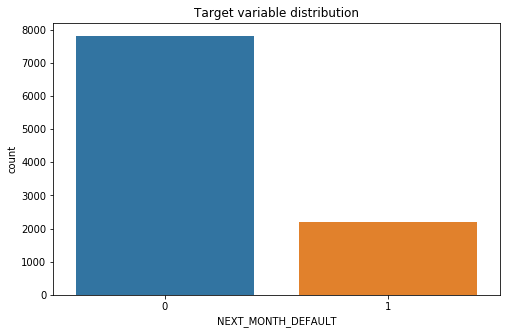

In [24]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

__Корреляция с базовыми признаками__

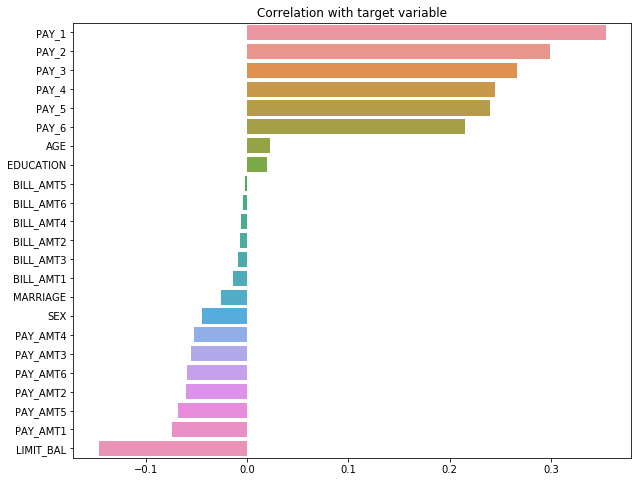

In [25]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

__Оценка признака "PAY_1" в разрезе целевой переменной__

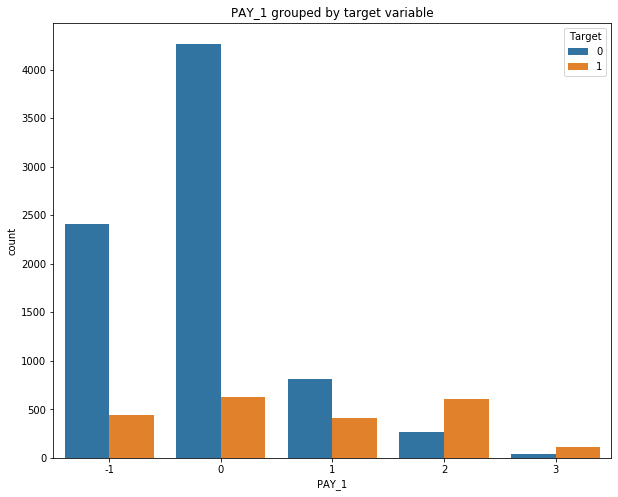

In [26]:
plt.figure(figsize=(10, 8))

sns.countplot(x="PAY_1", hue=TARGET_NAME, data=df)
plt.title('PAY_1 grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

__Наблюдение__

Изучив получившийся график, видно, что значения -1 (погашен полностью) и 0 (погашен частично) признака PAY_1 имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

__Гипотеза__

- Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
- Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
- Критерий: Хи-квадрат Пирсона
- Уровень значимости  α : 0.05
- Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий -1 и 0 признака PAY_1 в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

_Сформируем выборку и рассчитаем наблюдаемые частоты_

In [27]:
pay1_and_target_s = df.loc[df['PAY_1'].isin([-1, 0]), ['ID', 'PAY_1', 'NEXT_MONTH_DEFAULT']].sample(1000)

In [28]:
table = pay1_and_target_s.pivot_table(values='ID', index='PAY_1', columns='NEXT_MONTH_DEFAULT', aggfunc='count')
table

NEXT_MONTH_DEFAULT,0,1
PAY_1,,
-1,337,57
0,542,64


_Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона_

In [29]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.0642201829704783

Попарно проверить каждое значение. Удоблетворяющие значения редуцировать.

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории -1 (погашен полностью) и 0 (погашен частично) одинаково влияют на целевую переменную и их можно объединить в одну категорию.

_*Для других признаков PAY_2, PAY_3, и т.д. следует провести аналогичный анализ и после этого решать о целесообразности изменения категорий или построения новых признаков._

__Оценка признака "LIMIT_BAL" в разрезе целевой переменной__

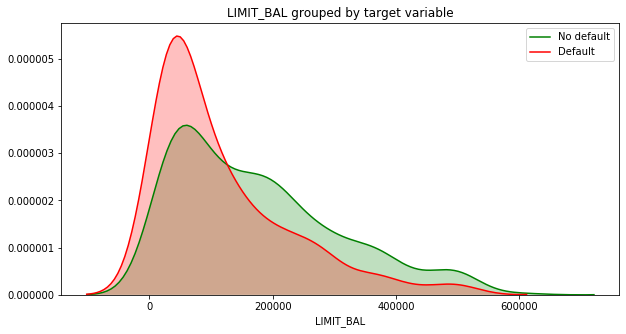

In [30]:
limit_bal_with_target_s = df[['LIMIT_BAL', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['LIMIT_BAL']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('LIMIT_BAL')
plt.title('LIMIT_BAL grouped by target variable')
plt.show()

__Наблюдение__

Похоже что две группы, полученные в результате разбиения признака "LIMIT_BAL" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "LIMIT_BAL" и целевой переменной, возможно, существует некоторая функциональная зависимость.

__Гипотеза__

- Нулевая гипотеза: средние значения в двух независимых выборках равны
- Альтернативная гипотеза: средние значения в двух независимых выборках различаются
- Критерий: критерий Стьюдента (t-тест) и его аналоги
- Уровень значимости  α : 0.05
- Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

_Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка_

In [31]:
shapiro(limit_bal_s)

(0.8985113501548767, 3.5437599084410245e-25)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

_Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график_

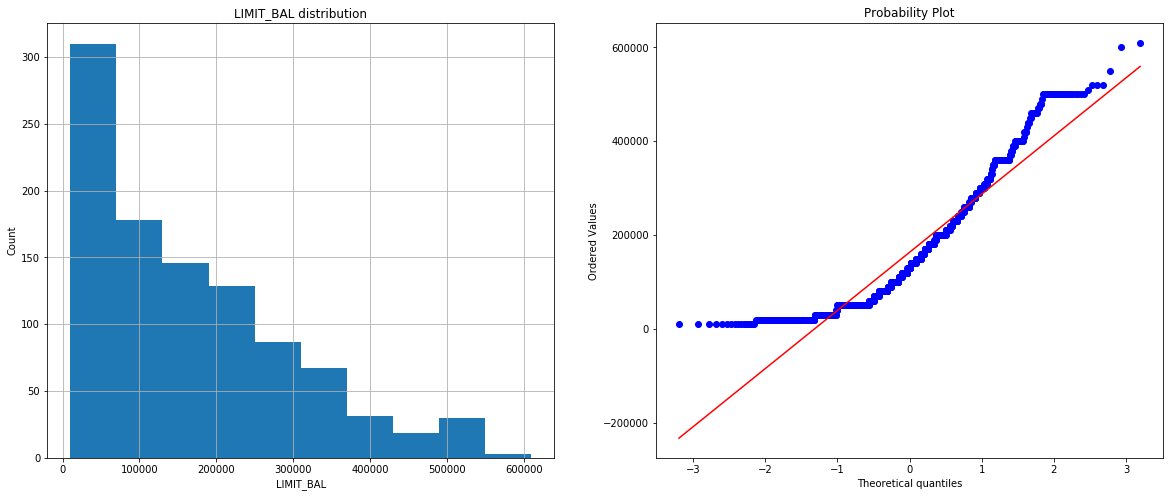

In [32]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('LIMIT_BAL')
ax1.set_ylabel('Count')
ax1.set_title('LIMIT_BAL distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака LIMIT_BAL в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

_Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни_

In [33]:
mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=58672.0, pvalue=1.8419560912393317e-10)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

_Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их_

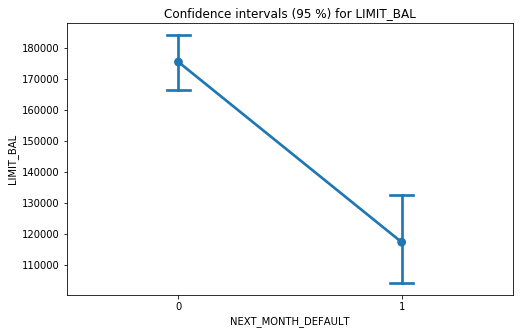

In [34]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='LIMIT_BAL', data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

__Матрица корреляций__

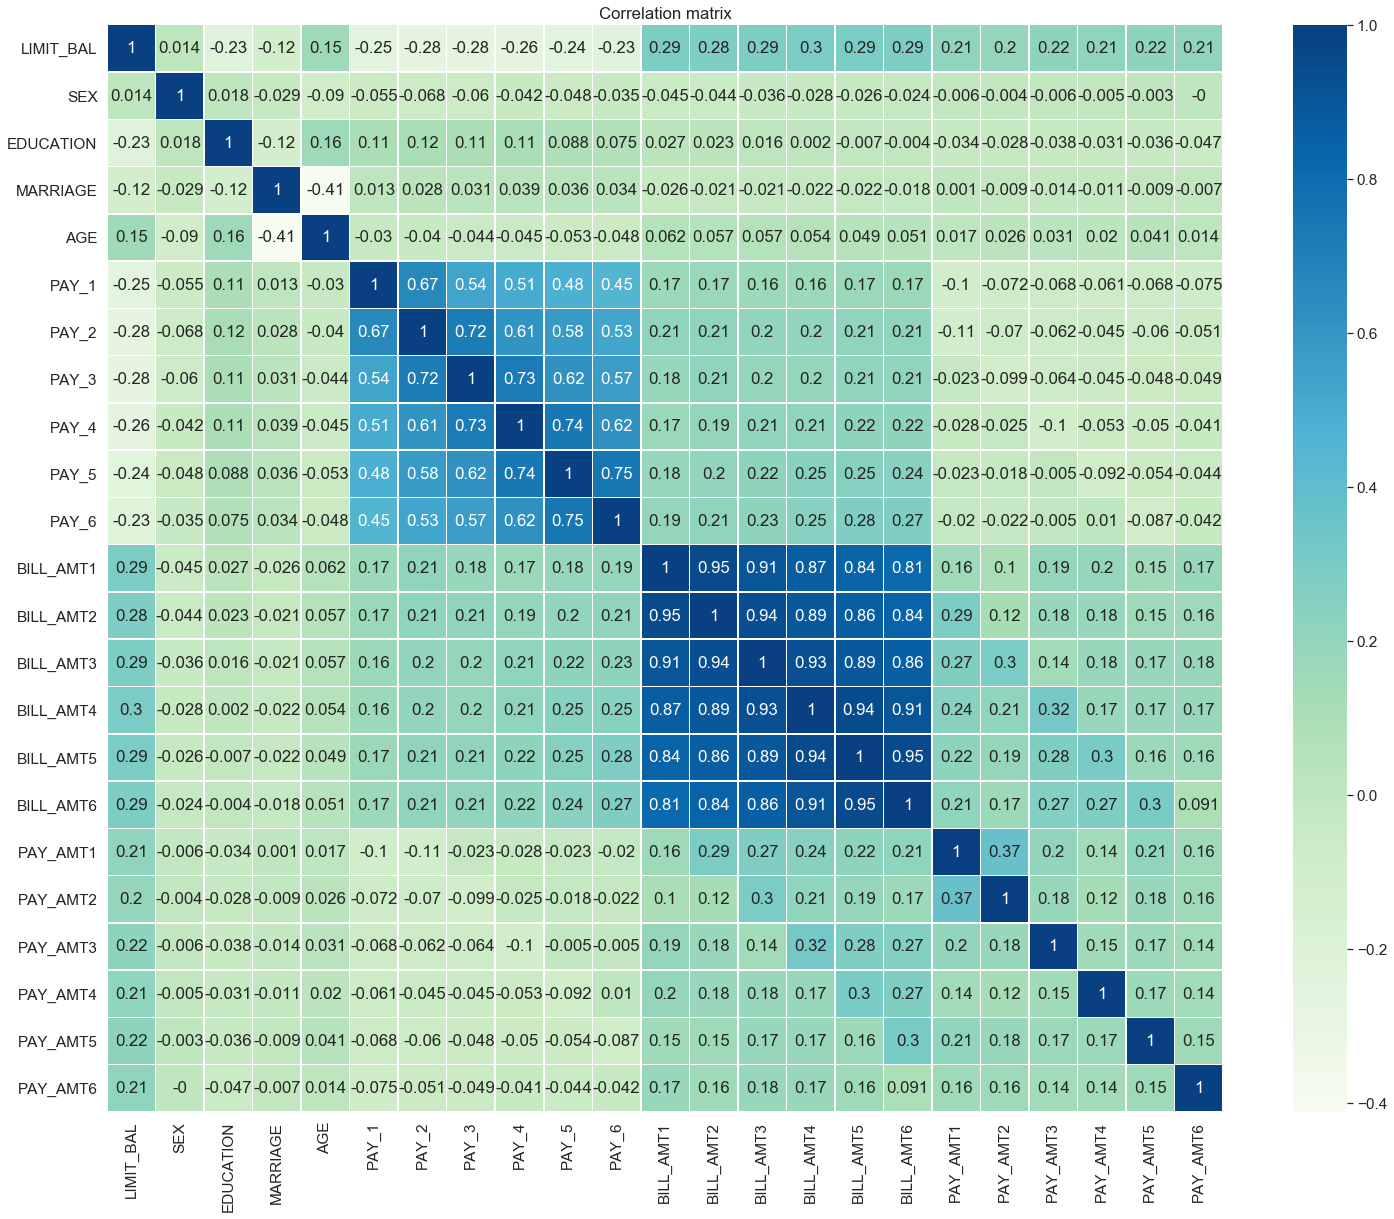

In [35]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

__Урок 3__

In [36]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [37]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [38]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков

In [39]:
NUMERIC_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                         'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

#### Нормализация данных

In [40]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

#### Разбиение на train и test

In [41]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

#### Балансировка целевой переменной

In [42]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    5852
1    4944
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [43]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей

#### Логистическая регрессия

In [44]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.87      0.76      5852
           1       0.77      0.52      0.62      4944

    accuracy                           0.71     10796
   macro avg       0.72      0.69      0.69     10796
weighted avg       0.72      0.71      0.70     10796

TEST

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1953
           1       0.54      0.54      0.54       547

    accuracy                           0.80      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.80      0.80      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1701  252
1                    254  293


#### k ближайших соседей

In [45]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      5852
           1       0.76      0.95      0.84      4944

    accuracy                           0.84     10796
   macro avg       0.85      0.85      0.84     10796
weighted avg       0.86      0.84      0.84     10796

TEST

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1953
           1       0.34      0.60      0.43       547

    accuracy                           0.66      2500
   macro avg       0.60      0.64      0.60      2500
weighted avg       0.74      0.66      0.69      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1326  627
1                    221  326


#### Бустинговые алгоритмы

_XGBoost_

In [46]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5852
           1       0.96      0.97      0.97      4944

    accuracy                           0.97     10796
   macro avg       0.97      0.97      0.97     10796
weighted avg       0.97      0.97      0.97     10796

TEST

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1953
           1       0.51      0.49      0.50       547

    accuracy                           0.79      2500
   macro avg       0.68      0.68      0.68      2500
weighted avg       0.78      0.79      0.78      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1699  254
1                    281  266


_LightGBM_

In [47]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      5852
           1       0.89      0.86      0.88      4944

    accuracy                           0.89     10796
   macro avg       0.89      0.89      0.89     10796
weighted avg       0.89      0.89      0.89     10796

TEST

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1953
           1       0.53      0.55      0.54       547

    accuracy                           0.80      2500
   macro avg       0.70      0.71      0.70      2500
weighted avg       0.80      0.80      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1686  267
1                    245  302


_CatBoost_

In [48]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5852
           1       0.90      0.86      0.88      4944

    accuracy                           0.89     10796
   macro avg       0.89      0.89      0.89     10796
weighted avg       0.89      0.89      0.89     10796

TEST

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1953
           1       0.53      0.55      0.54       547

    accuracy                           0.80      2500
   macro avg       0.70      0.71      0.71      2500
weighted avg       0.80      0.80      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1693  260
1                    248  299


### Выбор лучшей модели и подбор гиперпараметров

In [49]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

#### Подбор гиперпараметров

In [50]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [51]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [52]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 1min 40s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001E6F6581A08>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [53]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05}

In [54]:
rs.best_score_

0.8115475401984433

#### Обучение и оценка финальной модели

In [55]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5852
           1       0.90      0.86      0.88      4944

    accuracy                           0.89     10796
   macro avg       0.89      0.89      0.89     10796
weighted avg       0.89      0.89      0.89     10796

TEST

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1953
           1       0.54      0.54      0.54       547

    accuracy                           0.80      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.80      0.80      0.80      2500

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1702  251
1                    250  297
Wall time: 2.83 s


### Сохранение модели

#### Scaler

In [56]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

#### Model

In [57]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)